<a href="https://colab.research.google.com/github/hardiksahi/MachineLearning/blob/main/5_RidgeRegressionWorkedExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Follow example in https://www.statlect.com/machine-learning/choice-of-a-regularization-parameter

In [1]:
import numpy as np
import pandas as pd
import urllib.request

In [292]:
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [177]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
from numpy.linalg import cond, inv

In [128]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

In [419]:
import matplotlib.pyplot as plt
import seaborn as sns

In [381]:
def get_r2_predicted(X, y, model):
  loo_res = []
  for train_index, test_index in LeaveOneOut().split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    loo_res.append(*(y_test - model.predict(X_test)))

  centered_y = y.reshape(-1, ) - np.mean(y.reshape(-1, ))
  pred_rsq = 1 - np.sum(np.square(loo_res)) / (np.dot(centered_y, centered_y))

  return pred_rsq

In [382]:
## Retreive data
remoteAddress = 'https://www.statlect.com/ml-assets/y_hicp.csv'
localAddress = './y_hicp.csv'
try:
    y = pd.read_csv(localAddress, header=None)
except:
    urllib.request.urlretrieve(remoteAddress, localAddress)
    y = pd.read_csv(localAddress, header=None)
y = y.values # Transform y into a numpy array

In [8]:
print(f"Shape of y: {y.shape}")

Shape of y: (270, 1)


In [383]:
# Load the input variables with pandas
remoteAddress = 'https://www.statlect.com/ml-assets/x_hicp.csv'
localAddress = './x_hicp.csv'
try:
    x = pd.read_csv(localAddress, header=None)
except:
    urllib.request.urlretrieve(remoteAddress, localAddress)
    x = pd.read_csv(localAddress, header=None)
x_columns = x.columns

In [384]:
x = x.values
print(f"Shape of x: {x.shape}")

Shape of x: (270, 113)


In [11]:
## Split data into train, test and validation set
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.4, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=1)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (162, 113)
Shape of x_val: (54, 113)
Shape of x_test: (54, 113)


## Create benchmark model (OLS)

In [12]:
ols_model = sm.OLS(y_train,sm.add_constant(x_train), hasconst=True)
ols_model_results = ols_model.fit()

In [13]:
ols_model_train_prediction = ols_model.predict(params=ols_model_results.params, exog=sm.add_constant(x_train))
print(f"Shape of ols_model_train_prediction: {ols_model_train_prediction.shape}")

Shape of ols_model_train_prediction: (162,)


In [14]:
ols_model_val_prediction = ols_model.predict(params=ols_model_results.params, exog=sm.add_constant(x_val))
print(f"Shape of ols_model_val_prediction: {ols_model_val_prediction.shape}")

Shape of ols_model_val_prediction: (54,)


In [15]:
print(f"MSE on train set: {mean_squared_error(y_train, ols_model_train_prediction)}")
print(f"R2 on train set: {r2_score(y_train, ols_model_train_prediction)}")

MSE on train set: 0.014389920273540512
R2 on train set: 0.9084867354573687


In [16]:
print(f"MSE on val set: {mean_squared_error(y_val, ols_model_val_prediction)}")
print(f"R2 on val set: {r2_score(y_val, ols_model_val_prediction)}")

MSE on val set: 0.16796103899804601
R2 on val set: 0.28945157593066584


OLS regressor:
1. MSE train set is very low, R2 on train set is very high => LOW BIAS
2. abs(MSE Train - MSE val) = 0.1535 (Very high)
3. abs(R2 Train - R2 Val) = 0.61903515952 (Very high)Both 2 and 3 imply that the model has very high variance

=> Model is overfitting

## Ridge regression to handle overfitting

In [17]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)

In [18]:
x_val_scaled = x_scaler.transform(x_val)
y_val_scaled = y_scaler.transform(y_val)

In [19]:
lambda_val = 10

In [20]:
inverse_part = inv(np.dot(x_train_scaled.transpose(), x_train_scaled) + lambda_val*np.eye(x_train_scaled.shape[1]))

In [21]:
beta_ridge_coefficients = np.dot(inverse_part, np.dot(x_train_scaled.transpose(), y_train_scaled))

In [22]:
ridge_model_train_prediction = np.dot(x_train_scaled, beta_ridge_coefficients)
print(f"Shape of ridge_model_train_prediction: {ridge_model_train_prediction.shape}")

Shape of ridge_model_train_prediction: (162, 1)


In [23]:
ridge_model_val_prediction = np.dot(x_val_scaled, beta_ridge_coefficients)
print(f"Shape of ridge_model_val_prediction: {ridge_model_val_prediction.shape}")

Shape of ridge_model_val_prediction: (54, 1)


In [24]:
print(f"MSE on train set [Ridge]: {mean_squared_error(y_train_scaled, ridge_model_train_prediction)}")
print(f"R2 on train set [Ridge]: {r2_score(y_train_scaled, ridge_model_train_prediction)}")

MSE on train set [Ridge]: 0.10057794301203454
R2 on train set [Ridge]: 0.8994220569879654


In [25]:
print(f"MSE on val set [Ridge]: {mean_squared_error(y_val_scaled, ridge_model_val_prediction)}")
print(f"R2 on val set [Ridge]: {r2_score(y_val_scaled, ridge_model_val_prediction)}")

MSE on val set [Ridge]: 0.7677457820048922
R2 on val set [Ridge]: 0.48928700708706907


## Compare coefficients with the ones obtained from sklearn


In [26]:
sklearn_ridge_model = linear_model.Ridge(alpha = lambda_val, fit_intercept=False)

In [27]:
sklearn_ridge_model.fit(x_train_scaled, y_train_scaled)

Ridge(alpha=10, fit_intercept=False)

In [37]:
sklearn_ridge_coefficients = sklearn_ridge_model.coef_.reshape(-1, 1)

In [38]:
np.allclose(sklearn_ridge_coefficients, beta_ridge_coefficients)

True

## Compare coefficients with ones obtained from statsmodels. It uses different loss function (elastic_net) https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html#statsmodels.regression.linear_model.OLS.fit_regularized. Hence coeff are not same

In [42]:
stats_models_ridge_model = sm.OLS(x_train_scaled, y_train_scaled, hasconst=False)
stats_models_ridge_model_results = stats_models_ridge_model.fit_regularized(method="elastic_net", alpha=lambda_val, L1_wt=0)

# ============================================================================
# [Start] Use sklearn pipeline to train OLS and Ridge regression models, check for overfitting and choose best lambda for Ridge
# =====================================================================

## Step 1: Split x and y into train and test set

In [123]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (216, 113)
Shape of x_test: (54, 113)


In [124]:
## Scaled versiond of data
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Step 2: Train OLS on train data directly (on standardized version)

### Way 1: Train using statsmodels

In [141]:
statsmodels_ols_model = sm.OLS(y_train_scaled, x_train_scaled, hasconst=False)
statsmodels_ols_model_results = statsmodels_ols_model.fit()
statsmodels_ols_model_results_params = statsmodels_ols_model_results.params
print(f"Shape of statsmodels_ols_model_results_params: {statsmodels_ols_model_results_params.shape}")

Shape of statsmodels_ols_model_results_params: (113,)


In [142]:
## Predict on train set
statsmodels_ols_model_train_prediction = statsmodels_ols_model.predict(params=statsmodels_ols_model_results_params, exog=x_train_scaled)
print(f"Shape of statsmodels_ols_model_train_prediction: {statsmodels_ols_model_train_prediction.shape}")

Shape of statsmodels_ols_model_train_prediction: (216,)


In [143]:
## Predict on test set
statsmodels_ols_model_test_prediction = statsmodels_ols_model.predict(params=statsmodels_ols_model_results_params, exog=x_test_scaled)
print(f"Shape of statsmodels_ols_model_test_prediction: {statsmodels_ols_model_test_prediction.shape}")

Shape of statsmodels_ols_model_test_prediction: (54,)


### Way 2: Train using sklearn pipeline

In [144]:
sklearn_ols_standardize_pipeline = Pipeline([('scaler', StandardScaler(with_mean=True, with_std=True))])
sklearn_ols_pipeline = Pipeline(steps=[('standardize', sklearn_ols_standardize_pipeline), ('model',linear_model.LinearRegression(fit_intercept=False))])
sklearn_ols_model = TransformedTargetRegressor(regressor=sklearn_ols_pipeline, transformer=StandardScaler(with_mean=True, with_std=True))

In [145]:
sklearn_ols_model.fit(x_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('standardize',
                                                      Pipeline(steps=[('scaler',
                                                                       StandardScaler())])),
                                                     ('model',
                                                      LinearRegression(fit_intercept=False))]),
                           transformer=StandardScaler())

In [146]:
sklearn_ols_model_results_params = sklearn_ols_model.regressor_.named_steps["model"].coef_
print(f"Shape of sklearn_ols_model_results_params: {sklearn_ols_model_results_params.shape}")

Shape of sklearn_ols_model_results_params: (113,)


In [147]:
## Predict on train set
sklearn_ols_model_train_prediction = sklearn_ols_model.predict(x_train).reshape(-1, )
print(f"Shape of sklearn_ols_model_train_prediction: {sklearn_ols_model_train_prediction.shape}")

Shape of sklearn_ols_model_train_prediction: (216,)


In [148]:
## Predict on test set
sklearn_ols_model_test_prediction = sklearn_ols_model.predict(x_test).reshape(-1, )
print(f"Shape of sklearn_ols_model_test_prediction: {sklearn_ols_model_test_prediction.shape}")

Shape of sklearn_ols_model_test_prediction: (54,)


In [149]:
## Check if values are close using 2 approaches
np.allclose(statsmodels_ols_model_results_params, sklearn_ols_model_results_params)

True

In [158]:
np.allclose(y_scaler.inverse_transform(statsmodels_ols_model_train_prediction.reshape(-1, 1)).reshape(-1, ), sklearn_ols_model_train_prediction)

True

In [159]:
np.allclose(y_scaler.inverse_transform(statsmodels_ols_model_test_prediction.reshape(-1, 1)).reshape(-1, ), sklearn_ols_model_test_prediction)

True

## This shows that the predictions for both Way1 and Way2 are same (sklearn or statsmodels)

## Step 2.1 Check how the OLS model will perform on unseen data using CV (Basically check if model is under or overfitting)

In [161]:
sklearn_ols_cv_scores = cross_validate(sklearn_ols_model, x_train, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

In [162]:
sklearn_ols_cv_scores

{'fit_time': array([0.00811911, 0.00926828, 0.00532484, 0.00516939, 0.12037563]),
 'score_time': array([0.00147533, 0.00126743, 0.00107789, 0.00112772, 0.00152493]),
 'test_r2': array([ 0.2928094 , -0.29596513, -0.04464911, -0.35850734,  0.02348783]),
 'train_r2': array([0.89491606, 0.90161087, 0.91569828, 0.90356863, 0.89363159]),
 'test_neg_mean_squared_error': array([-0.13319731, -0.25449225, -0.14856253, -0.17378526, -0.15944091]),
 'train_neg_mean_squared_error': array([-0.01682528, -0.01572579, -0.01447745, -0.01696388, -0.01775269])}

In [165]:
sklearn_ols_bias_score_based_on_r2 = np.mean(sklearn_ols_cv_scores["train_r2"])
sklearn_ols_bias_score_based_on_neg_mean_squared_error = np.mean(sklearn_ols_cv_scores["train_neg_mean_squared_error"])
print(f"sklearn_ols_bias_score_based_on_r2: {sklearn_ols_bias_score_based_on_r2}")
print(f"sklearn_ols_bias_score_based_on_neg_mean_squared_error: {sklearn_ols_bias_score_based_on_neg_mean_squared_error}")

sklearn_ols_bias_score_based_on_r2: 0.9018850880030043
sklearn_ols_bias_score_based_on_neg_mean_squared_error: -0.016349015974874873


In [215]:
sklearn_ols_variance_score_based_on_r2 = np.mean(100*(sklearn_ols_cv_scores["test_r2"] - sklearn_ols_cv_scores["train_r2"])/sklearn_ols_cv_scores["train_r2"])
print(f"sklearn_ols_variance_score_based_on_r2: {sklearn_ols_variance_score_based_on_r2}%")

sklearn_ols_variance_score_based_on_r2: -108.40629754932186%


In [216]:
sklearn_ols_variance_score_based_on_neg_mean_squared_error = np.mean(100*(sklearn_ols_cv_scores["test_neg_mean_squared_error"] - sklearn_ols_cv_scores["train_neg_mean_squared_error"])/sklearn_ols_cv_scores["train_neg_mean_squared_error"])
print(f"sklearn_ols_variance_score_based_on_neg_mean_squared_error: {sklearn_ols_variance_score_based_on_neg_mean_squared_error}%")

sklearn_ols_variance_score_based_on_neg_mean_squared_error: 971.7384765905368%


## Check https://machinelearningcompass.com/model_optimization/bias_and_variance/ to see how to quantify variance

In [210]:
# sklearn_ols_variance_score_based_on_r2 = np.sqrt(np.mean((sklearn_ols_cv_scores["train_r2"] - sklearn_ols_cv_scores["test_r2"])**2))
# print(f"sklearn_ols_variance_score_based_on_r2: {sklearn_ols_variance_score_based_on_r2}")
# np.sqrt(mean_squared_error(sklearn_ols_cv_scores["train_r2"], sklearn_ols_cv_scores["test_r2"]))

In [214]:
# sklearn_ols_variance_score_based_on_neg_mean_squared_error = np.sqrt(np.mean((sklearn_ols_cv_scores["train_neg_mean_squared_error"] - sklearn_ols_cv_scores["test_neg_mean_squared_error"])**2))
# print(f"sklearn_ols_variance_score_based_on_neg_mean_squared_error: {sklearn_ols_variance_score_based_on_neg_mean_squared_error}")
# np.sqrt(mean_squared_error(sklearn_ols_cv_scores["train_neg_mean_squared_error"], sklearn_ols_cv_scores["test_neg_mean_squared_error"]))

## This shows that the model has very low bias. Also, model has very high variance. This shows model overfits a lot!!

In [192]:
print(f"Expected train set r2: {np.mean(sklearn_ols_cv_scores['train_r2'])}")
print(f"Expected test set r2: {np.mean(sklearn_ols_cv_scores['test_r2'])}")

print(f"Expected train set mse: {np.abs(np.mean(sklearn_ols_cv_scores['train_neg_mean_squared_error']))}")
print(f"Expected test set mse: {np.abs(np.mean(sklearn_ols_cv_scores['test_neg_mean_squared_error']))}")

Expected train set r2: 0.9018850880030043
Expected test set r2: -0.07656486993768477
Expected train set mse: 0.016349015974874873
Expected test set mse: 0.17389565347384223


In [206]:
print(f"Actual train set r2: {r2_score(y_train, sklearn_ols_model_train_prediction)}")
print(f"Actual train set mse: {mean_squared_error(y_train, sklearn_ols_model_train_prediction)}")

Actual train set r2: 0.8637173797873098
Actual train set mse: 0.02277531779280668


In [193]:
print(f"Actual test set r2: {r2_score(y_test, sklearn_ols_model_test_prediction)}")
print(f"Actual test set mse: {mean_squared_error(y_test, sklearn_ols_model_test_prediction)}")

Actual test set r2: 0.374929696536931
Actual test set mse: 0.15434360319929916


## Step 2.2 Another way to see overfitting is to calculate predicted R2 (ONLY FOR LINEAR REGRESSION!!)
- https://statisticsbyjim.com/regression/overfitting-regression-models/
- https://statisticsbyjim.com/regression/interpret-adjusted-r-squared-predicted-r-squared-regression/
- https://stats.stackexchange.com/questions/592653/how-to-get-predicted-r-square-from-statmodels

In [235]:
sklean_ols_predicted_r2 = get_r2_predicted(x_train, y_train, TransformedTargetRegressor(regressor=sklearn_ols_pipeline, transformer=StandardScaler(with_mean=True, with_std=True)))
print(f"sklean_ols_predicted_r2: {sklean_ols_predicted_r2}")

sklean_ols_predicted_r2: 0.3696968808415816


In [236]:
print(f"Difference between R2 and predicted R2: {r2_score(y_train, sklearn_ols_model_train_prediction) - sklean_ols_predicted_r2}")

Difference between R2 and predicted R2: 0.4940204989457282


## Since there is a large discrepancy between R2 and predicted R2 => MODEL OVERFITS!!!!

## Step 3: Train Ridge on train data directly (on standardized version)

### Way 1: Train using self implementation (Note: statsmodels implements different loss function. Hence results cannot be compared directly with sklearn)

In [262]:
lambda_val = 30

In [263]:
self_model_inverse_part = inv(np.dot(x_train_scaled.transpose(), x_train_scaled) + lambda_val*np.eye(x_train_scaled.shape[1]))

In [264]:
self_model_beta_ridge_coefficients = np.dot(self_model_inverse_part, np.dot(x_train_scaled.transpose(), y_train_scaled))

In [265]:
## Predict on train set
self_ridge_model_train_prediction = np.dot(x_train_scaled, self_model_beta_ridge_coefficients)
print(f"Shape of self_ridge_model_train_prediction: {self_ridge_model_train_prediction.shape}")

Shape of self_ridge_model_train_prediction: (216, 1)


In [266]:
## Predict on test set
self_ridge_model_test_prediction = np.dot(x_test_scaled, self_model_beta_ridge_coefficients)
print(f"Shape of self_ridge_model_test_prediction: {self_ridge_model_test_prediction.shape}")

Shape of self_ridge_model_test_prediction: (54, 1)


### Way 2: Train using sklearn pipeline

In [267]:
sklearn_ridge_standardize_pipeline = Pipeline([('scaler', StandardScaler(with_mean=True, with_std=True))])
sklearn_ridge_pipeline = Pipeline(steps=[('standardize', sklearn_ridge_standardize_pipeline), ('model',linear_model.Ridge(alpha=lambda_val, fit_intercept=False))])
sklearn_ridge_model = TransformedTargetRegressor(regressor=sklearn_ridge_pipeline, transformer=StandardScaler(with_mean=True, with_std=True))

In [268]:
sklearn_ridge_model.fit(x_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('standardize',
                                                      Pipeline(steps=[('scaler',
                                                                       StandardScaler())])),
                                                     ('model',
                                                      Ridge(alpha=30,
                                                            fit_intercept=False))]),
                           transformer=StandardScaler())

In [269]:
sklearn_ridge_model_results_params = sklearn_ridge_model.regressor_.named_steps["model"].coef_
print(f"Shape of sklearn_ridge_model_results_params: {sklearn_ridge_model_results_params.shape}")

Shape of sklearn_ridge_model_results_params: (113,)


In [270]:
## Predict on train set
sklearn_ridge_model_train_prediction = sklearn_ridge_model.predict(x_train).reshape(-1, )
print(f"Shape of sklearn_ridge_model_train_prediction: {sklearn_ridge_model_train_prediction.shape}")

Shape of sklearn_ridge_model_train_prediction: (216,)


In [271]:
## Predict on test set
sklearn_ridge_model_test_prediction = sklearn_ridge_model.predict(x_test).reshape(-1, )
print(f"Shape of sklearn_ridge_model_test_prediction: {sklearn_ridge_model_test_prediction.shape}")

Shape of sklearn_ridge_model_test_prediction: (54,)


In [272]:
## Check if values are close using 2 approaches
np.allclose(self_model_beta_ridge_coefficients.reshape(-1, ), sklearn_ridge_model_results_params)

True

In [273]:
np.allclose(y_scaler.inverse_transform(self_ridge_model_train_prediction.reshape(-1, 1)).reshape(-1, ), sklearn_ridge_model_train_prediction)

True

In [274]:
np.allclose(y_scaler.inverse_transform(self_ridge_model_test_prediction.reshape(-1, 1)).reshape(-1, ), sklearn_ridge_model_test_prediction)

True

## This shows that the predictions for both Way1 and Way2 are same (self model or statsmodels)

## Step 3.1 Use CV to see if model overfits. This specific model with lambda = lambda_val

In [275]:
sklearn_ridge_cv_scores = cross_validate(sklearn_ridge_model, x_train, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

In [276]:
sklearn_ridge_cv_scores

{'fit_time': array([0.00795889, 0.00591874, 0.00620127, 0.00465298, 0.00595355]),
 'score_time': array([0.00131679, 0.0012455 , 0.00184774, 0.00125003, 0.00140047]),
 'test_r2': array([0.52524276, 0.2937116 , 0.24282193, 0.58453916, 0.54975049]),
 'train_r2': array([0.86642478, 0.87156885, 0.89236223, 0.85605022, 0.85902678]),
 'test_neg_mean_squared_error': array([-0.08941916, -0.1386958 , -0.10768046, -0.05314728, -0.0735149 ]),
 'train_neg_mean_squared_error': array([-0.02138709, -0.02052748, -0.01848503, -0.02532316, -0.02352817])}

In [277]:
sklearn_ridge_bias_score_based_on_r2 = np.mean(sklearn_ridge_cv_scores["train_r2"])
sklearn_ridge_bias_score_based_on_neg_mean_squared_error = np.mean(sklearn_ridge_cv_scores["train_neg_mean_squared_error"])
print(f"sklearn_ridge_bias_score_based_on_r2: {sklearn_ridge_bias_score_based_on_r2}")
print(f"sklearn_ridge_bias_score_based_on_neg_mean_squared_error: {sklearn_ridge_bias_score_based_on_neg_mean_squared_error}")

sklearn_ridge_bias_score_based_on_r2: 0.8690865690656169
sklearn_ridge_bias_score_based_on_neg_mean_squared_error: -0.02185018728733839


In [278]:
sklearn_ridge_variance_score_based_on_r2 = np.mean(100*(sklearn_ridge_cv_scores["test_r2"] - sklearn_ridge_cv_scores["train_r2"])/sklearn_ridge_cv_scores["train_r2"])
print(f"sklearn_ridge_variance_score_based_on_r2: {sklearn_ridge_variance_score_based_on_r2}%")

sklearn_ridge_variance_score_based_on_r2: -49.23752912207975%


In [279]:
sklearn_ridge_variance_score_based_on_neg_mean_squared_error = np.mean(100*(sklearn_ridge_cv_scores["test_neg_mean_squared_error"] - sklearn_ridge_cv_scores["train_neg_mean_squared_error"])/sklearn_ridge_cv_scores["train_neg_mean_squared_error"])
print(f"sklearn_ridge_variance_score_based_on_neg_mean_squared_error: {sklearn_ridge_variance_score_based_on_neg_mean_squared_error}%")

sklearn_ridge_variance_score_based_on_neg_mean_squared_error: 339.72331464808263%


## It is very clear that as lamba increase bias increases and variance decreases. Hence model is getting regularized/ less overfitting!!!

In [280]:
print(f"Expected train set r2: {np.mean(sklearn_ridge_cv_scores['train_r2'])}")
print(f"Expected test set r2: {np.mean(sklearn_ridge_cv_scores['test_r2'])}")

print(f"Expected train set mse: {np.abs(np.mean(sklearn_ridge_cv_scores['train_neg_mean_squared_error']))}")
print(f"Expected test set mse: {np.abs(np.mean(sklearn_ridge_cv_scores['test_neg_mean_squared_error']))}")

Expected train set r2: 0.8690865690656169
Expected test set r2: 0.4392131859213057
Expected train set mse: 0.02185018728733839
Expected test set mse: 0.09249151940370359


In [281]:
print(f"Actual train set r2: {r2_score(y_train, sklearn_ridge_model_train_prediction)}")
print(f"Actual train set mse: {mean_squared_error(y_train, sklearn_ridge_model_train_prediction)}")

Actual train set r2: 0.8440643226287541
Actual train set mse: 0.02605970300412522


In [283]:
print(f"Actual test set r2: {r2_score(y_test, sklearn_ridge_model_test_prediction)}")
print(f"Actual test set mse: {mean_squared_error(y_test, sklearn_ridge_model_test_prediction)}")

Actual test set r2: 0.5088587873149075
Actual test set mse: 0.12127356559016127


## Actual test set performance is now closer to what is expected from CV !!!

## Step 3.2 Another way to see overfitting is to calculate predicted R2 (ONLY FOR LINEAR REGRESSION!!)

In [284]:
sklean_ridge_predicted_r2 = get_r2_predicted(x_train, y_train, TransformedTargetRegressor(regressor=sklearn_ridge_pipeline, transformer=StandardScaler(with_mean=True, with_std=True)))
print(f"sklean_ridge_predicted_r2: {sklean_ridge_predicted_r2}")

sklean_ridge_predicted_r2: 0.5195777858723686


In [285]:
print(f"Difference between R2 and predicted R2: {r2_score(y_train, sklearn_ridge_model_train_prediction) - sklean_ridge_predicted_r2}")

Difference between R2 and predicted R2: 0.3244865367563855


## Difference between R2 and R_predicted has reduced => Overfitting is reduced!!!!

## Step 4: Use CV to choose best Ridge param lambda [Hyperparameter tuning!!!]

Search for the best ridge model
In the following code:

we estimate several Ridge regression models (with different values of the regularization parameter) on the training set;

we perform model selection, choosing the Ridge regression that has the best performance on the validation set;

we check the performance of the chosen model on the test set.

Check : https://www.statlect.com/machine-learning/choice-of-a-regularization-parameter

In [457]:
cv_sklearn_ridge_standardize_pipeline = Pipeline([('scaler', StandardScaler(with_mean=True, with_std=True))])
cv_sklearn_ridge_pipeline = Pipeline(steps=[('standardize', cv_sklearn_ridge_standardize_pipeline), ('model',linear_model.Ridge(fit_intercept=False))])
cv_sklearn_ridge_model = TransformedTargetRegressor(regressor=cv_sklearn_ridge_pipeline, transformer=StandardScaler(with_mean=True, with_std=True))

In [458]:
#cv_grid_params = {"regressor__model__alpha": 10 * 0.90 ** np.arange(1,300)}
cv_grid_params = {"regressor__model__alpha": np.linspace(0.1, 2000)}

In [459]:
grid_cv =  GridSearchCV(cv_sklearn_ridge_model, cv_grid_params, return_train_score=True, refit="neg_mean_squared_error", cv=5, scoring=('r2', 'neg_mean_squared_error'))

In [460]:
grid_cv.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('standardize',
                                                                             Pipeline(steps=[('scaler',
                                                                                              StandardScaler())])),
                                                                            ('model',
                                                                             Ridge(fit_intercept=False))]),
                                                  transformer=StandardScaler()),
             param_grid={'regressor__model__alpha': array([1.00000000e-01, 4.09142857e+01, 8.17285714e+01, 1.22542857e+02,
       1.63357143e+02, 2.04171429e+02, 2.4...
       1.30615714e+03, 1.34697143e+03, 1.38778571e+03, 1.42860000e+03,
       1.46941429e+03, 1.51022857e+03, 1.55104286e+03, 1.59185714e+03,
       1.63267143e+03, 1.67348571e+03, 1.71430000e+03, 1.75511429e+03,
       1.79592857e+03, 1.83674286e+03, 1.87755714e+03, 1.91837143e+03,
       1.95918571e+03, 2.00000000e+03])},
             refit='neg_mean_squared_error', return_train_score=True,
             scoring=('r2', 'neg_mean_squared_error'))

In [461]:
hyperparam_cv_results = pd.DataFrame.from_records(grid_cv.cv_results_)

In [462]:
sorted_by_mse_hyperparam_cv_results = hyperparam_cv_results.sort_values(by=["rank_test_neg_mean_squared_error"], ascending=True)

In [463]:
print(f"Best model sklearn_ridge_bias_score_based_on_r2: {sorted_by_mse_hyperparam_cv_results.iloc[0]['mean_train_r2']}")
print(f"Best model sklearn_ridge_bias_score_based_on_mse: {sorted_by_mse_hyperparam_cv_results.iloc[0]['mean_train_neg_mean_squared_error']}")

Best model sklearn_ridge_bias_score_based_on_r2: 0.8090739984721415
Best model sklearn_ridge_bias_score_based_on_mse: -0.03187824763958709


In [476]:
best_model_hyperparam_df = sorted_by_mse_hyperparam_cv_results.reset_index(drop=True).iloc[0].reset_index().rename(columns={0: "val"})#.query("index.str.contains(r'(split\d+_train_neg_mean_squared_error)', regex=True)")

In [478]:
best_model_hyperparam_train_df = best_model_hyperparam_df[best_model_hyperparam_df["index"].str.contains(r"split\d+_train_neg_mean_squared_error")]
best_model_hyperparam_train_df = best_model_hyperparam_train_df.rename(columns={"val": "train_neg_mean_squared_error"})
best_model_hyperparam_train_df["index"] = best_model_hyperparam_train_df["index"].str.extract(r"(split\d+)", expand=False)

In [479]:
best_model_hyperparam_train_df.head()

,index,train_neg_mean_squared_error
12,split0,-0.031156
16,split1,-0.029259
20,split2,-0.028601
24,split3,-0.036549
28,split4,-0.033825


In [480]:
best_model_hyperparam_val_df = best_model_hyperparam_df[best_model_hyperparam_df["index"].str.contains(r"split\d+_test_neg_mean_squared_error")]
best_model_hyperparam_val_df = best_model_hyperparam_val_df.rename(columns={"val": "val_neg_mean_squared_error"})
best_model_hyperparam_val_df["index"] = best_model_hyperparam_val_df["index"].str.extract(r"(split\d+)", expand=False)

In [481]:
best_model_df = best_model_hyperparam_train_df.merge(best_model_hyperparam_val_df, left_on=["index"], right_on=["index"], how="left")

In [482]:
best_model_df

,index,train_neg_mean_squared_error,val_neg_mean_squared_error
0,split0,-0.031156,-0.091692
1,split1,-0.029259,-0.132338
2,split2,-0.028601,-0.093835
3,split3,-0.036549,-0.049278
4,split4,-0.033825,-0.06326


In [483]:
best_model_sklearn_ridge_variance_score_based_on_neg_mean_squared_error = np.mean(100*(best_model_df["val_neg_mean_squared_error"] - best_model_df["train_neg_mean_squared_error"])/best_model_df["train_neg_mean_squared_error"])
print(f"best_model_sklearn_ridge_variance_score_based_on_neg_mean_squared_error: {best_model_sklearn_ridge_variance_score_based_on_neg_mean_squared_error}%")

best_model_sklearn_ridge_variance_score_based_on_neg_mean_squared_error: 179.3033335109857%


In [484]:
best_model_hyperparam_r2_train_df = best_model_hyperparam_df[best_model_hyperparam_df["index"].str.contains(r"split\d+_train_r2")]
best_model_hyperparam_r2_train_df = best_model_hyperparam_r2_train_df.rename(columns={"val": "train_r2"})
best_model_hyperparam_r2_train_df["index"] = best_model_hyperparam_r2_train_df["index"].str.extract(r"(split\d+)", expand=False)

In [485]:
best_model_hyperparam_r2_val_df = best_model_hyperparam_df[best_model_hyperparam_df["index"].str.contains(r"split\d+_test_r2")]
best_model_hyperparam_r2_val_df = best_model_hyperparam_r2_val_df.rename(columns={"val": "val_r2"})
best_model_hyperparam_r2_val_df["index"] = best_model_hyperparam_r2_val_df["index"].str.extract(r"(split\d+)", expand=False)

In [486]:
best_model_r2_df = best_model_hyperparam_r2_train_df.merge(best_model_hyperparam_r2_val_df, left_on=["index"], right_on=["index"], how="left")

In [487]:
best_model_sklearn_ridge_variance_score_based_on_r2 = np.mean(100*(best_model_r2_df["val_r2"] - best_model_r2_df["train_r2"])/best_model_r2_df["train_r2"])
print(f"best_model_sklearn_ridge_variance_score_based_on_r2: {best_model_sklearn_ridge_variance_score_based_on_r2}%")

best_model_sklearn_ridge_variance_score_based_on_r2: -40.224847959146736%


In [489]:
print(f"Best model Expected train set r2: {sorted_by_mse_hyperparam_cv_results.iloc[0]['mean_train_r2']}")
print(f"Best model Expected test set r2: {sorted_by_mse_hyperparam_cv_results.iloc[0]['mean_test_r2']}")

print(f"Best model Expected train set mse: {np.abs(sorted_by_mse_hyperparam_cv_results.iloc[0]['mean_train_neg_mean_squared_error'])}")
print(f"Best model Expected test set mse: {np.abs(sorted_by_mse_hyperparam_cv_results.iloc[0]['mean_test_neg_mean_squared_error'])}")

Best model Expected train set r2: 0.8090739984721415
Best model Expected test set r2: 0.4813585802653931
Best model Expected train set mse: 0.03187824763958709
Best model Expected test set mse: 0.08608042843210786


In [490]:
best_model_estimator = grid_cv.best_estimator_

In [491]:
best_model_estimator.regressor_.named_steps["model"]

Ridge(alpha=81.72857142857143, fit_intercept=False)

In [492]:
print(f"Best model Actual train set r2: {r2_score(y_train, best_model_estimator.predict(x_train))}")
print(f"Best model Actual train set mse: {mean_squared_error(y_train, best_model_estimator.predict(x_train))}")

Best model Actual train set r2: 0.800041465540275
Best model Actual train set mse: 0.033416727390453094


In [493]:
print(f"Best model Actual test set r2: {r2_score(y_test, best_model_estimator.predict(x_test))}")
print(f"Best model Actual test set mse: {mean_squared_error(y_test, best_model_estimator.predict(x_test))}")

Best model Actual test set r2: 0.5084550494818155
Best model Actual test set mse: 0.1213732573393326


## Step 4.2 Another way to see overfitting is to calculate predicted R2 (ONLY FOR LINEAR REGRESSION!!)

In [519]:
grid_cv.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('standardize',
                                                      Pipeline(steps=[('scaler',
                                                                       StandardScaler())])),
                                                     ('model',
                                                      Ridge(alpha=81.72857142857143,
                                                            fit_intercept=False))]),
                           transformer=StandardScaler())

In [495]:
best_model_sklean_ridge_predicted_r2 = get_r2_predicted(x_train, y_train, grid_cv.best_estimator_)
print(f"best_model_sklean_ridge_predicted_r2: {best_model_sklean_ridge_predicted_r2}")

best_model_sklean_ridge_predicted_r2: 0.5349059100096937


In [496]:
print(f"Best modelDifference between R2 and predicted R2: {r2_score(y_train, best_model_estimator.predict(x_train)) - best_model_sklean_ridge_predicted_r2}")

Best modelDifference between R2 and predicted R2: 0.2649653358859132


In [533]:
np.argsort(-np.abs(grid_cv.best_estimator_.regressor_.named_steps["model"].coef_))

array([ 11,   1,   5,  10,   9,  24,  79,  22,  15,   7,  63,  37,  84,
        21, 102,   0,  61,   2,  23,  31,  94,  96, 110,  81,  41,  16,
        35,  33,  64,  62,  59,  13,  85,  86,  57,  12, 105, 103,  27,
        18,  29,  83, 107,  45,  80,  36,  20,  93,  82,  92, 111, 112,
        17,  42,  87,  55, 100,  56,  60,  38, 104,  78,  88,  49,  66,
         4,  50,  51,  58,  73,  19,  40,  54,  71,  39,  69,  32,  98,
        72,  14,  97,  28,  76,  44,  67,  26,  43, 101,  75,  99,  47,
        74,  90,  89, 106,  46,  30,  91,   8,  53,  70,  25,   3,  68,
       109,  34,  48,  52,  77, 108,   6,  95,  65])

## Step 5: PLot coeffcient importance for best model using cross validation
- https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

In [520]:
best_cv_model = cross_validate(
    grid_cv.best_estimator_,
    x_train,
    y_train,
    cv=5,
    return_estimator=True,
    n_jobs=2,
)

In [523]:
best_cv_model["estimator"][0]

TransformedTargetRegressor(regressor=Pipeline(steps=[('standardize',
                                                      Pipeline(steps=[('scaler',
                                                                       StandardScaler())])),
                                                     ('model',
                                                      Ridge(alpha=81.72857142857143,
                                                            fit_intercept=False))]),
                           transformer=StandardScaler())

In [524]:
best_coefs = pd.DataFrame(
    [model.regressor_.named_steps["model"].coef_ for model in best_cv_model["estimator"]],
    columns=x_columns,
)

In [528]:
best_coefs

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0.063296,0.247193,0.050064,-0.019147,0.013365,-0.167701,-0.009258,0.069486,-0.001230,-0.096773,...,-0.015576,0.025438,-0.028072,-0.006533,-0.049081,-0.002103,0.001193,0.031669,0.029642,-0.028770
1,0.062718,0.184122,0.082665,-0.016144,0.017837,-0.151787,0.010233,0.083893,-0.007200,-0.095407,...,-0.076686,0.034154,-0.052767,-0.037311,-0.024304,-0.008546,0.009020,0.055962,0.013026,0.010598
2,0.068101,0.209971,0.049403,0.024241,0.020412,-0.147759,-0.006215,0.075953,-0.001012,-0.092102,...,-0.004174,0.003561,-0.042730,0.003322,-0.009986,-0.008500,-0.020521,0.049362,0.023353,-0.030833
3,0.050713,0.237472,0.049853,0.002480,0.026666,-0.132581,0.006352,0.058186,0.002188,-0.105777,...,-0.031850,0.007693,-0.034861,-0.011047,-0.053092,0.003734,0.014328,0.061103,0.013819,-0.020527
4,0.055586,0.250773,0.048046,-0.002007,0.013141,-0.151538,-0.008286,0.097200,-0.025189,-0.126527,...,-0.053589,0.042852,-0.024766,-0.011907,-0.008755,-0.001539,-0.011582,0.051948,0.018061,-0.024471


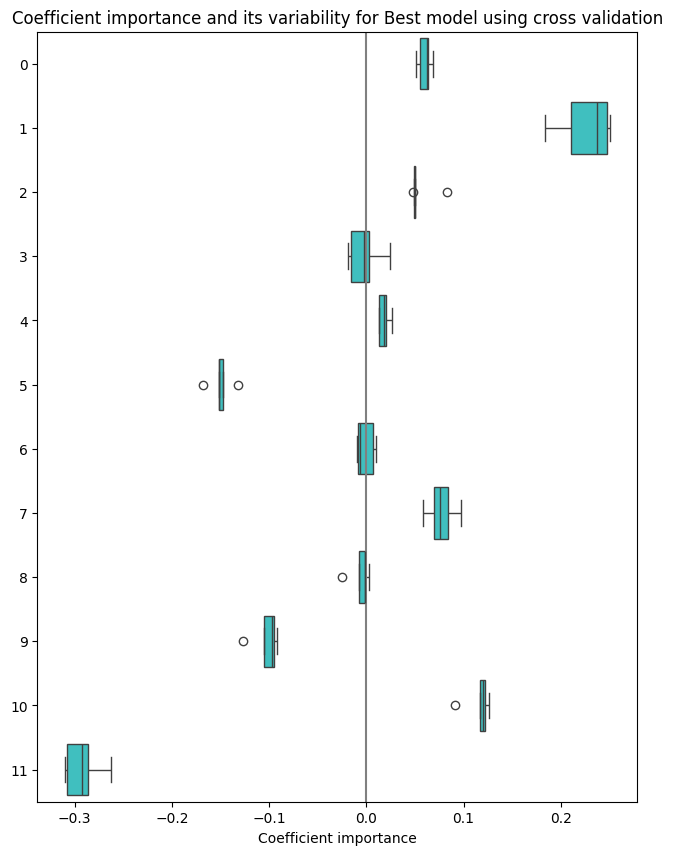

In [534]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=best_coefs[[0,1,2,3,4,5, 6, 7, 8, 9, 10, 11]], orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability for Best model using cross validation")
plt.subplots_adjust(left=0.3)

## Step 6: PLot coefficient paths for different values of lambda
- https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py
- https://bookdown.org/ssjackson300/Machine-Learning-Lecture-Notes/ridge-regression.html


In [515]:
alphas = np.linspace(0.1, 2000)#10 * 0.90 ** np.arange(1,300)

In [516]:
coefs_df = pd.DataFrame()
for a in alphas:
  sklearn_ridge_standardize_pipeline = Pipeline([('scaler', StandardScaler(with_mean=True, with_std=True))])
  sklearn_ridge_pipeline = Pipeline(steps=[('standardize', sklearn_ridge_standardize_pipeline), ('model',linear_model.Ridge(alpha=a, fit_intercept=False))])
  sklearn_ridge_model = TransformedTargetRegressor(regressor=sklearn_ridge_pipeline, transformer=StandardScaler(with_mean=True, with_std=True))
  sklearn_ridge_model.fit(x_train, y_train)
  coefficients = sklearn_ridge_model.regressor_.named_steps["model"].coef_
  this_coeff_df = pd.DataFrame({"standardized_coeff": coefficients})
  this_coeff_df["feature_name"] = [f"f{f}" for f in x_columns]
  this_coeff_df["alpha"] = a
  coefs_df = pd.concat([coefs_df, this_coeff_df], axis=0)

In [517]:
subset_coeff_df = coefs_df[coefs_df.feature_name.isin([f"f{i}"for i in range(0, 10, 1)])]#coefs_df[coefs_df.feature_name.str.contains(r"f[012345]$", regex=True)]

Text(0.5, 1.0, 'Ridge coefficients as a function of the regularization')

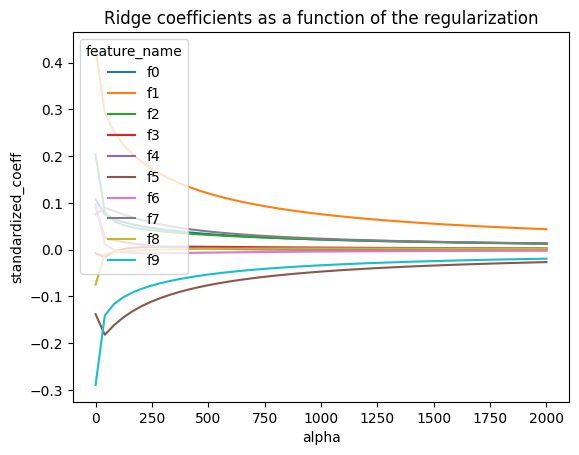

In [518]:
sns.lineplot(data=subset_coeff_df, x="alpha", y="standardized_coeff", hue="feature_name").set_title("Ridge coefficients as a function of the regularization")

The features that see maximum shrinkage are the ones that L2 regression considers as important.

1. https://scikit-learn.org/stable/auto_examples/linear_model/plot_huber_vs_ridge.html#sphx-glr-auto-examples-linear-model-plot-huber-vs-ridge-py
2. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py
3. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_coeffs.html#sphx-glr-auto-examples-linear-model-plot-ridge-coeffs-py
